In [1]:
import pandas as pd
import math
import numpy as np

%matplotlib inline

from pathlib import Path
from omegaconf import OmegaConf
import scipy.stats as st

In [2]:
# Collect predictions

def check_num_epochs(run):
    if Path(run / "valid_log.csv").is_file():
        cfg = OmegaConf.load(run / '.hydra' / 'config.yaml')
        cfg = OmegaConf.to_container(cfg)
        num_epochs = cfg['optim']['epochs']

        valid_log = pd.read_csv(run / "valid_log.csv", header=None, index_col=0)
        if (len(valid_log.index)-3) < num_epochs:
            print("Wrong number of epochs in run: {}".format(run))
    else:
        print("valid_log.csv not exists in run: {}".format(run))

def check_only_one_tensorboard(run):
    len(list(Path('.').glob('*')))
    if len(list(Path(run / "runs").glob('*'))) > 1:
        print("More than 1 tensorboard folder in run: {}".format(run))

def check_image_size(run, image_size=480):
    cfg = OmegaConf.load(run / '.hydra' / 'config.yaml')
    cfg = OmegaConf.to_container(cfg)
    conf_image_size = cfg['data']['image_size']
    if int(conf_image_size) != image_size:
        print("Different image size in conf. Image size in conf: {}, Image size: {}".format(conf_image_size, image_size))

def collect_one(model_name, run, csv_file, image_size=480):
    check_num_epochs(run)
    check_only_one_tensorboard(run)
    check_image_size(run, image_size=image_size)
    
    cfg = OmegaConf.load(run / '.hydra' / 'config.yaml')
    cfg = OmegaConf.to_container(cfg)

    run_number = cfg['data']['train']['cross_val_bucket_validation_index']
    regime, inv_temp = float(run.parent.parts[-1].rsplit('-', 1)[1]), float(run.parent.parts[-2].rsplit('-', 1)[1])

    csv_path = run / 'test_predictions' / csv_file
    if not csv_path.exists():
        print(f'Skipping not found: {csv_path}')
        return pd.DataFrame()
    
    data = pd.read_csv(csv_path)
    if data.empty:
        print(f'Pred file is empty: {csv_path}')

    data['model'] = model_name
    data['run_number'] = run_number
    data['inv_temp'] = inv_temp
    data['regime'] = regime
    
    return data

def collect_all(model_name, root, csv_file, regimes=['0.01', '0.02', '0.05', '0.1', '0.2', '0.25', '1.0'], image_size=480, ignore_outliers=True):
    root = Path(root)

    metrics = []
    for inv_temp in list(root.glob("inv_temp-*")):
        for regime in list(inv_temp.glob("regime-*")):
            if regime.name.rsplit("-", 1)[1] in regimes:
                for run in list(regime.glob("run-*")):
                    if ignore_outliers and 'outlier' in run.as_posix():
                        continue
                    else:
                        metrics.append(collect_one(model_name, run, csv_file, image_size=image_size))
        
    metrics = pd.concat(metrics, ignore_index=True)
    
    return metrics

def collect_all_temperature(model_name, root, csv_file, regimes=['0.01', '0.02', '0.05', '0.1', '0.2', '0.25', '1.0'], image_size=480, ignore_outliers=True):
    root = Path(root)

    metrics = []
    for regime in list(root.glob("regime-*")):
        if regime.name.rsplit("-", 1)[1] in regimes:
            for run in list(regime.glob("run-*")):
                if ignore_outliers and 'outlier' in run.as_posix():
                    continue
                else:
                    metrics.append(collect_one(model_name, run, csv_file, image_size=image_size))
        
    metrics = pd.concat(metrics, ignore_index=True)
    
    return metrics

In [3]:
# Compute metrics for each detected run

def compute_metrics(data, grouping, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance']):
    metrics_dict_names = {
        'Dice': 'dice',
        'Jaccard': 'jaccard',
        'Hausdorff Distance': '95hd',
        'Average Surface Distance': 'asd'
    }

    columns = ['Model', '# Run', 'Inv Temp', 'Regime']
    columns.extend(metric_names)
    metrics = []
    
    data = data.copy().reset_index()
    grouped = data.groupby(grouping)
    
    for model_group, predictions in grouped:
        model_name, run_number, inv_temp, regime = model_group[0], model_group[1], model_group[2], model_group[3]
        
        metric_values = []
        for metric_name in metric_names:
            values = predictions['segm/{}'.format(metrics_dict_names[metric_name])].values
            mean_value = np.nanmean(values)
            if metric_name == 'Dice' or metric_name == 'Jaccard':
                metric_values.append((math.ceil(mean_value*10000)/10000)*100)
            else:
                if not np.isnan(mean_value):
                    metric_values.append(math.ceil(mean_value*100)/100)
                else:
                    metric_values.append(mean_value)
        
        metrics.append([model_name, run_number, inv_temp, regime, *metric_values])
        
    metrics_df = pd.DataFrame(metrics, columns=columns)
    
    return metrics_df

def summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90, return_ranges=False):

    def compute_ci(values, return_ranges=False):
        ci = st.t.interval(confidence_level, len(values)-1, loc=np.mean(values), scale=np.std(values)/(len(values)**0.5))

        if return_ranges:
            return ci
        else:
            return (ci[1]-ci[0]) / 2

    #mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ('STD', np.std), ("CI {}%".format(confidence_level), compute_ci)])
    mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)]) 

    return mean_metrics

<h1>GlaS Dataset</h1>

<h2>Evaluation - Searching temperature hyperparameter</h2>

<p>Evaluate Hebbian models belonging to SWTA paradigm to search best temperature values (this value is dataset-specific)</p>

In [120]:
# Unsupervised learning models are evaluate over the whole dataset while fine tuned models over a fraction of data

EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['1.0']
IMAGE_SIZE = 480

runs = {
    'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-swta')),
    'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-swta_t')),
}

In [121]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds_from_last.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_all(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [122]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA,0,1.0,1.0,47.30,32.27,41.72,8.55
1,H-UNet-BASE-SWTA,0,5.0,1.0,51.05,36.06,42.40,8.16
2,H-UNet-BASE-SWTA,0,10.0,1.0,46.77,31.51,45.59,8.88
3,H-UNet-BASE-SWTA,0,20.0,1.0,50.54,35.32,38.32,7.20
4,H-UNet-BASE-SWTA,0,50.0,1.0,51.47,36.11,42.11,7.88
5,H-UNet-BASE-SWTA,0,100.0,1.0,53.66,38.14,40.05,7.27
6,H-UNet-BASE-SWTA-T,0,1.0,1.0,44.46,30.72,44.54,9.98
7,H-UNet-BASE-SWTA-T,0,5.0,1.0,50.81,35.78,54.12,10.52
8,H-UNet-BASE-SWTA-T,0,10.0,1.0,51.88,36.82,42.02,8.29
9,H-UNet-BASE-SWTA-T,0,20.0,1.0,51.90,36.60,42.04,7.84


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-BASE-SWTA   1.0      1.0     47.30     NaN   32.27     NaN   
                   5.0      1.0     51.05     NaN   36.06     NaN   
                   10.0     1.0     46.77     NaN   31.51     NaN   
                   20.0     1.0     50.54     NaN   35.32     NaN   
                   50.0     1.0     51.47     NaN   36.11     NaN   
                   100.0    1.0     53.66     NaN   38.14     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0     44.46     NaN   30.72     NaN   
                   5.0      1.0     50.81     NaN   35.78     NaN   
                   10.0     1.0     51.88     NaN   36.82     NaN   
                   20.0     1.0     51.90     NaN   36.60     NaN   
                   50.0     1.0     47.79     NaN   32.60     NaN   
                   100.0    1.0     49.70     NaN   34.92     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-BASE-SWTA   1.0      1.0                 41.72     NaN   
                   5.0      1.0                 42.40     NaN   
                   10.0     1.0                 45.59     NaN   
                   20.0     1.0                 38.32     NaN   
                   50.0     1.0                 42.11     NaN   
                   100.0    1.0                 40.05     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0                 44.54     NaN   
                   5.0      1.0                 54.12     NaN   
                   10.0     1.0                 42.02     NaN   
                   20.0     1.0                 42.04     NaN   
                   50.0     1.0                 43.38     NaN   
                   100.0    1.0                 41.65     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-BASE-SWTA   1.0      1.0                        8.55     NaN  
                   5.0      1.0                        8.16     NaN  
                   10.0     1.0                        8.88     NaN  
                   20.0     1.0                        7.20     NaN  
                   50.0     1.0                        7.88     NaN  
                   100.0    1.0                        7.27     NaN  
H-UNet-BASE-SWTA-T 1.0      1.0                        9.98     NaN  
                   5.0      1.0                       10.52     NaN  
                   10.0     1.0                        8.29     NaN  
                   20.0     1.0                        7.84     NaN  
                   50.0     1.0                        8.20     NaN  
                   100.0    1.0                        8.29     NaN

In [7]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2']
IMAGE_SIZE = 480
REGIMES = ['0.1']

runs = {
    #'H-UNet-BASE-SWTA-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-swta_ft')),
    'H-UNet-BASE-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-swta_t_ft')),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet-swta_t_ft')),
}

In [8]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [9]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA-T-FT,0,1.0,0.1,71.21,56.92,33.65,5.01
1,H-UNet-BASE-SWTA-T-FT,0,5.0,0.1,76.65,63.82,28.81,4.28
2,H-UNet-BASE-SWTA-T-FT,0,10.0,0.1,76.90,63.63,31.85,4.36
3,H-UNet-BASE-SWTA-T-FT,0,20.0,0.1,76.73,63.80,30.74,4.31
4,H-UNet-BASE-SWTA-T-FT,0,50.0,0.1,76.79,63.48,33.18,4.55
5,H-UNet-BASE-SWTA-T-FT,0,100.0,0.1,76.97,63.68,30.91,4.41
6,H-UNet-BASE-SWTA-T-FT,1,1.0,0.1,79.28,67.10,41.45,6.14
7,H-UNet-BASE-SWTA-T-FT,1,5.0,0.1,80.76,69.56,29.41,4.34
8,H-UNet-BASE-SWTA-T-FT,1,10.0,0.1,79.61,68.00,38.87,5.96
9,H-UNet-BASE-SWTA-T-FT,1,20.0,0.1,79.72,68.46,29.90,4.43


/tmp/ipykernel_1652997/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f151c1da050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_1652997/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f151c1da050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice           Jaccard            \
                                         Mean   CI 0.9%    Mean   CI 0.9%   
Model                 Inv Temp Regime                                       
H-UNet-BASE-SWTA-T-FT 1.0      0.1     77.069  1.638427  64.415  2.039758   
                      5.0      0.1     78.799  1.321929  66.882  1.815796   
                      10.0     0.1     79.284  1.071966  67.392  1.449789   
                      20.0     0.1     79.803  1.209938  68.223  1.553301   
                      50.0     0.1     79.816  1.555917  68.153  2.099536   
                      100.0    0.1     79.363  0.956632  67.564  1.352758   

                                      Hausdorff Distance            \
                                                    Mean   CI 0.9%   
Model                 Inv Temp Regime                                
H-UNet-BASE-SWTA-T-FT 1.0      0.1                37.508  3.315807   
                      5.0      0.1                35.429  3.977506   
                      10.0     0.1                35.270  3.164784   
                      20.0     0.1                32.577  3.180316   
                      50.0     0.1                32.654  3.026168   
                      100.0    0.1                33.125  3.033588   

                                      Average Surface Distance            
                                                          Mean   CI 0.9%  
Model                 Inv Temp Regime                                     
H-UNet-BASE-SWTA-T-FT 1.0      0.1                       5.650  0.599442  
                      5.0      0.1                       5.233  0.609449  
                      10.0     0.1                       5.174  0.581355  
                      20.0     0.1                       4.808  0.559912  
                      50.0     0.1                       4.727  0.553345  
                      100.0    0.1                       4.921  0.452407

<h2>Evaluation - Hebbian Unsupervised Pretraining</h2>

<p>Evaluate Hebbian models pretrained in an unsupervised way over the datasets; only best temperature values for SWTA are considered.</p>

In [127]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

IMAGE_SIZE = 480
INV_TEMP_GlaS=1          # to be set accordingly, used by SWTA

runs = {
    'H-UNet-HPCA': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-hpca/inv_temp-1/regime-1.0').glob('run-*')),
    'H-UNet-HPCA-T': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-hpca_t/inv_temp-1/regime-1.0').glob('run-*')),
    #'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-swta/inv_temp-{}/regime-1.0'.format(INV_TEMP_GlaS)).glob('run-*')),
    #'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-swta_t/inv_temp-{}/regime-1.0'.format(INV_TEMP_GlaS)).glob('run-*')),
    'VAE-UNet-BASE': list(Path(EXP_ROOT + '/experiment=glas/vae-unet_base/inv_temp-1/regime-1.0').glob('run-*')),
}

In [128]:
# Collect predictions scanning runs
predictions = pd.concat([collect_one(k, r, 'preds_from_last.csv', image_size=IMAGE_SIZE) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_one(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [129]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

/tmp/ipykernel_2318543/3550580355.py:24: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(values)


,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-HPCA,0,1.0,1.0,0.01,0.01,NaN,NaN
1,H-UNet-HPCA-T,0,1.0,1.0,0.01,0.01,NaN,NaN
2,VAE-UNet-BASE,0,1.0,1.0,55.34,40.07,43.12,8.29


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                Mean CI 0.9%    Mean CI 0.9%   
Model         Inv Temp Regime                                  
H-UNet-HPCA   1.0      1.0      0.01     NaN    0.01     NaN   
H-UNet-HPCA-T 1.0      1.0      0.01     NaN    0.01     NaN   
VAE-UNet-BASE 1.0      1.0     55.34     NaN   40.07     NaN   

                              Hausdorff Distance          \
                                            Mean CI 0.9%   
Model         Inv Temp Regime                              
H-UNet-HPCA   1.0      1.0                   NaN     NaN   
H-UNet-HPCA-T 1.0      1.0                   NaN     NaN   
VAE-UNet-BASE 1.0      1.0                 43.12     NaN   

                              Average Surface Distance          
                                                  Mean CI 0.9%  
Model         Inv Temp Regime                                   
H-UNet-HPCA   1.0      1.0                         NaN     NaN  
H-UNet-HPCA-T 1.0      1.0                         NaN     NaN  
VAE-UNet-BASE 1.0      1.0                        8.29     NaN

<h2>Evaluation - Data regime variations</h2>

<p>Evaluate Hebbian models over the datasets, by varying the quantity of training data; only fine-tuned models are considered since during pre-training we can consider the whole dataset; only best temperature values for SWTA are considered.</p>

In [4]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2', '1.0']       # regimes to be considered
IMAGE_SIZE = 480
INV_TEMP_GlaS=20          # to be set accordingly, used by SWTA

runs = {
    #'UNet': list(Path(EXP_ROOT + '/experiment=glas/').glob('unet_base')),
    #'UNet-Pseudolabeling': list(Path(EXP_ROOT + '/experiment=glas').glob('unet')),
    #'H-UNet-HPCA-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-hpca_ft')),
    #'H-UNet-HPCA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('hunet_base-hpca_t_ft')),
    'UNet-Wavelet': list(Path(EXP_ROOT + '/experiment=glas').glob('wavelet-unet')),
    #'UNet-Perturbed': list(Path(EXP_ROOT + '/experiment=glas').glob('perturbed-unet')),
    #'VAE-UNet-FT': list(Path(EXP_ROOT + '/experiment=glas/').glob('vae-unet_base_ft')),
    #'UNet-Teacher': list(Path(EXP_ROOT + '/experiment=glas').glob('teacher-unet')),
}

runs_swta = {
    #'H-UNet-SWTA-FT': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-swta_ft').glob('inv_temp-{}'.format(INV_TEMP_GlaS))),
    #'H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/hunet_base-swta_t_ft').glob('inv_temp-{}'.format(INV_TEMP_GlaS))),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=glas/hunet-swta_t_ft/inv_temp-{}'.format(INV_TEMP_GlaS)).glob('regime-*')),
}

In [5]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)
if bool([a for a in runs_swta.values() if a != []]):
    predictions_swta = pd.concat([collect_all_temperature(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs_swta.items() for r in v], ignore_index=True)
    predictions = pd.concat([predictions, predictions_swta])

Skipping not found: /home/luca/datino/results/hebbian-medical-image-segmentation/runs/experiment=glas/wavelet-unet/inv_temp-1/regime-0.05/run-4/test_predictions/preds.csv


In [6]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics, confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,UNet-Wavelet,0,1.0,0.01,65.84,50.98,61.63,9.51
1,UNet-Wavelet,0,1.0,0.02,65.97,51.13,61.50,9.49
2,UNet-Wavelet,0,1.0,0.05,65.98,51.14,61.50,9.49
3,UNet-Wavelet,0,1.0,0.10,66.04,51.21,61.57,9.49
4,UNet-Wavelet,0,1.0,0.20,69.32,55.31,56.74,8.99
5,UNet-Wavelet,1,1.0,0.01,65.79,50.91,61.24,9.47
6,UNet-Wavelet,1,1.0,0.02,65.86,50.99,61.30,9.47
7,UNet-Wavelet,1,1.0,0.05,65.93,51.07,61.37,9.47
8,UNet-Wavelet,2,1.0,0.01,66.03,51.20,61.57,9.49
9,UNet-Wavelet,2,1.0,0.02,65.93,51.07,61.37,9.47


/tmp/ipykernel_1401459/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3bcc19a050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_1401459/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3bcc19a050> is currently using SeriesGroupBy.mean. In a

Dice              Jaccard            \
                                 Mean   CI 0.9%       Mean   CI 0.9%   
Model        Inv Temp Regime                                           
UNet-Wavelet 1.0      0.01    65.9630  0.220691  51.101000  0.235188   
                      0.02    65.8500  0.064600  50.973333  0.081806   
                      0.05    67.1725  2.498453  52.640000  3.145583   
                      0.10    66.0400       NaN  51.210000       NaN   
                      0.20    69.3200       NaN  55.310000       NaN   

                             Hausdorff Distance            \
                                           Mean   CI 0.9%   
Model        Inv Temp Regime                                
UNet-Wavelet 1.0      0.01               60.667  1.410156   
                      0.02               61.155  0.223921   
                      0.05               59.825  3.237741   
                      0.10               61.570       NaN   
                      0.20               56.740       NaN   

                             Average Surface Distance            
                                                 Mean   CI 0.9%  
Model        Inv Temp Regime                                     
UNet-Wavelet 1.0      0.01                     9.3640  0.225766  
                      0.02                     9.4400  0.036171  
                      0.05                     9.3175  0.324535  
                      0.10                     9.4900       NaN  
                      0.20                     8.9900       NaN

<h1>PH2 Dataset</h1>

<h2>Evaluation - Searching temperature hyperparameter</h2>

<p>Evaluate Hebbian models belonging to SWTA paradigm to search best temperature values (this value is dataset-specific)</p>

In [133]:
# Unsupervised learning models are evaluate over the whole dataset while fine tuned models over a fraction of data

EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['1.0']
IMAGE_SIZE = 480

runs = {
    'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-swta')),
    'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-swta_t')),
}

In [134]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds_from_last.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_all(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [135]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA,0,1.0,1.0,37.87,24.53,88.37,19.27
1,H-UNet-BASE-SWTA,0,5.0,1.0,62.55,47.35,128.40,17.75
2,H-UNet-BASE-SWTA,0,10.0,1.0,52.52,37.05,128.04,21.26
3,H-UNet-BASE-SWTA,0,20.0,1.0,66.37,51.55,118.39,16.46
4,H-UNet-BASE-SWTA,0,50.0,1.0,68.06,54.63,67.03,10.53
5,H-UNet-BASE-SWTA,0,100.0,1.0,66.43,51.49,128.33,18.33
6,H-UNet-BASE-SWTA-T,0,1.0,1.0,46.58,31.37,142.65,29.84
7,H-UNet-BASE-SWTA-T,0,5.0,1.0,67.24,52.35,128.85,18.26
8,H-UNet-BASE-SWTA-T,0,10.0,1.0,66.75,51.93,118.49,16.77
9,H-UNet-BASE-SWTA-T,0,20.0,1.0,58.91,43.78,128.75,20.37


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-BASE-SWTA   1.0      1.0     37.87     NaN   24.53     NaN   
                   5.0      1.0     62.55     NaN   47.35     NaN   
                   10.0     1.0     52.52     NaN   37.05     NaN   
                   20.0     1.0     66.37     NaN   51.55     NaN   
                   50.0     1.0     68.06     NaN   54.63     NaN   
                   100.0    1.0     66.43     NaN   51.49     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0     46.58     NaN   31.37     NaN   
                   5.0      1.0     67.24     NaN   52.35     NaN   
                   10.0     1.0     66.75     NaN   51.93     NaN   
                   20.0     1.0     58.91     NaN   43.78     NaN   
                   50.0     1.0     68.97     NaN   54.37     NaN   
                   100.0    1.0     70.49     NaN   57.17     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-BASE-SWTA   1.0      1.0                 88.37     NaN   
                   5.0      1.0                128.40     NaN   
                   10.0     1.0                128.04     NaN   
                   20.0     1.0                118.39     NaN   
                   50.0     1.0                 67.03     NaN   
                   100.0    1.0                128.33     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0                142.65     NaN   
                   5.0      1.0                128.85     NaN   
                   10.0     1.0                118.49     NaN   
                   20.0     1.0                128.75     NaN   
                   50.0     1.0                108.32     NaN   
                   100.0    1.0                 92.96     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-BASE-SWTA   1.0      1.0                       19.27     NaN  
                   5.0      1.0                       17.75     NaN  
                   10.0     1.0                       21.26     NaN  
                   20.0     1.0                       16.46     NaN  
                   50.0     1.0                       10.53     NaN  
                   100.0    1.0                       18.33     NaN  
H-UNet-BASE-SWTA-T 1.0      1.0                       29.84     NaN  
                   5.0      1.0                       18.26     NaN  
                   10.0     1.0                       16.77     NaN  
                   20.0     1.0                       20.37     NaN  
                   50.0     1.0                       14.29     NaN  
                   100.0    1.0                       12.72     NaN

In [77]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2']
IMAGE_SIZE = 480

runs = {
    #'H-UNet-BASE-SWTA-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-swta_ft')),
    'H-UNet-BASE-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-swta_t_ft')),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet-swta_t_ft')),
}

In [80]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

In [79]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA-T-FT,0,1.0,0.01,78.12,66.53,87.31,10.44
1,H-UNet-BASE-SWTA-T-FT,0,1.0,0.02,86.15,78.32,21.06,3.61
2,H-UNet-BASE-SWTA-T-FT,0,1.0,0.05,85.33,77.06,18.87,2.97
3,H-UNet-BASE-SWTA-T-FT,0,1.0,0.10,90.90,84.26,5.69,0.93
4,H-UNet-BASE-SWTA-T-FT,0,1.0,0.20,90.19,82.95,9.75,1.38
...,...,...,...,...,...,...,...,...
294,H-UNet-BASE-SWTA-T-FT,9,100.0,0.01,82.04,72.89,37.16,5.56
295,H-UNet-BASE-SWTA-T-FT,9,100.0,0.02,82.45,73.40,23.79,4.70
296,H-UNet-BASE-SWTA-T-FT,9,100.0,0.05,85.32,76.34,17.15,2.45
297,H-UNet-BASE-SWTA-T-FT,9,100.0,0.10,84.86,76.73,18.05,3.78


/tmp/ipykernel_4034542/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f7954e36050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_4034542/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f7954e36050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice              Jaccard  \
                                            Mean   CI 0.9%       Mean   
Model                 Inv Temp Regime                                   
H-UNet-BASE-SWTA-T-FT 1.0      0.01    73.760000  5.854617  63.108000   
                               0.02    81.655000  2.224007  72.141000   
                               0.05    86.438000  1.656712  78.083000   
                               0.10    89.704000  1.015932  82.354000   
                               0.20    90.289000  0.737205  83.069000   
                      5.0      0.01    77.847778  3.568195  67.991111   
                               0.02    80.705000  1.447742  70.984000   
                               0.05    85.313000  1.877434  76.427000   
                               0.10    88.363000  1.732454  80.705000   
                               0.20    90.605000  0.829383  83.755000   
                      10.0     0.01    70.599000  6.789344  60.771000   
                               0.02    80.118000  4.741301  70.588000   
                               0.05    85.778000  2.697651  77.251000   
                               0.10    88.916000  1.380825  81.301000   
                               0.20    91.463000  0.618110  84.879000   
                      20.0     0.01    74.123000  4.144249  64.240000   
                               0.02    77.852000  3.864554  67.814000   
                               0.05    83.177000  2.337717  74.366000   
                               0.10    88.763000  1.502124  80.960000   
                               0.20    90.879000  1.094715  84.110000   
                      50.0     0.01    72.946000  3.698877  62.819000   
                               0.02    81.565000  2.211274  71.688000   
                               0.05    83.723000  2.574189  75.074000   
                               0.10    87.802000  2.080241  80.100000   
                               0.20    91.395000  1.092364  84.893000   
                      100.0    0.01    71.134000  5.903978  60.012000   
                               0.02    81.598000  2.901766  72.228000   
                               0.05    83.384000  2.225288  74.440000   
                               0.10    88.329000  1.473197  80.489000   
                               0.20    91.706000  0.914832  85.212000   

                                                Hausdorff Distance             \
                                        CI 0.9%               Mean    CI 0.9%   
Model                 Inv Temp Regime                                           
H-UNet-BASE-SWTA-T-FT 1.0      0.01    6.001539          50.672000  13.110059   
                               0.02    2.915542          27.629000   7.344586   
                               0.05    2.224161          19.789000   6.066662   
                               0.10    1.459911          11.109000   3.835059   
                               0.20    1.071973          11.833000   3.204681   
                      5.0      0.01    4.133133          39.606667   9.517440   
                               0.02    1.409465          35.816000   6.778049   
                               0.05    2.450160          22.796000   5.650493   
                               0.10    2.246248          15.681000   6.077191   
                               0.20    1.145337           9.962000   3.724200   
                      10.0     0.01    6.272131          54.675000  13.373462   
                               0.02    5.519999          32.562000  11.557975   
                               0.05    3.442579          21.541000   8.751598   
                               0.10    1.806360          13.998000   4.158693   
                               0.20    0.974456          10.298000   3.793987   
                      20.0     0.01    4.568574          51.178000   9.690714   
                               0.02    4.407365          40.021000   9.789978   
              

<h2>Evaluation - Hebbian Unsupervised Pretraining</h2>

<p>Evaluate Hebbian models pretrained in an unsupervised way over the datasets; only best temperature values for SWTA are considered.</p>

In [138]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

IMAGE_SIZE = 480
INV_TEMP_PH2=100          # to be set accordingly, used by SWTA

runs = {
    'H-UNet-HPCA': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-hpca/inv_temp-1/regime-1.0').glob('run-*')),
    'H-UNet-HPCA-T': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-hpca_t/inv_temp-1/regime-1.0').glob('run-*')),
    #'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-swta/inv_temp-{}/regime-1.0'.format(INV_TEMP_PH2)).glob('run-*')),
    #'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-swta_t/inv_temp-{}/regime-1.0'.format(INV_TEMP_PH2)).glob('run-*')),
    'VAE-UNet-BASE': list(Path(EXP_ROOT + '/experiment=ph2/vae-unet_base/inv_temp-1/regime-1.0').glob('run-*')),
}

In [139]:
# Collect predictions scanning runs
predictions = pd.concat([collect_one(k, r, 'preds_from_last.csv', image_size=IMAGE_SIZE) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_one(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [140]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

/tmp/ipykernel_2318543/3550580355.py:24: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(values)


,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-HPCA,0,1.0,1.0,0.02,0.01,246.21,86.46
1,H-UNet-HPCA-T,0,1.0,1.0,0.01,0.01,NaN,NaN
2,VAE-UNet-BASE,0,1.0,1.0,81.36,71.16,48.19,6.00


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                Mean CI 0.9%    Mean CI 0.9%   
Model         Inv Temp Regime                                  
H-UNet-HPCA   1.0      1.0      0.02     NaN    0.01     NaN   
H-UNet-HPCA-T 1.0      1.0      0.01     NaN    0.01     NaN   
VAE-UNet-BASE 1.0      1.0     81.36     NaN   71.16     NaN   

                              Hausdorff Distance          \
                                            Mean CI 0.9%   
Model         Inv Temp Regime                              
H-UNet-HPCA   1.0      1.0                246.21     NaN   
H-UNet-HPCA-T 1.0      1.0                   NaN     NaN   
VAE-UNet-BASE 1.0      1.0                 48.19     NaN   

                              Average Surface Distance          
                                                  Mean CI 0.9%  
Model         Inv Temp Regime                                   
H-UNet-HPCA   1.0      1.0                       86.46     NaN  
H-UNet-HPCA-T 1.0      1.0                         NaN     NaN  
VAE-UNet-BASE 1.0      1.0                        6.00     NaN

<h2>Evaluation - Data regime variations</h2>

<p>Evaluate Hebbian models over the datasets, by varying the quantity of training data; only fine-tuned models are considered since during pre-training we can consider the whole dataset; only best temperature values for SWTA are considered.</p>

In [7]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2', '1.0']       # regimes to be considered
IMAGE_SIZE = 480
INV_TEMP_PH2=100          # to be set accordingly, used by SWTA

runs = {
    #'UNet': list(Path(EXP_ROOT + '/experiment=ph2/').glob('unet_base')),
    #'UNet-Pseudolabeling': list(Path(EXP_ROOT + '/experiment=ph2').glob('unet')),
    #'H-UNet-HPCA-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-hpca_ft')),
    #'H-UNet-HPCA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('hunet_base-hpca_t_ft')),
    'UNet-Wavelet': list(Path(EXP_ROOT + '/experiment=ph2').glob('wavelet-unet')),
    #'UNet-Perturbed': list(Path(EXP_ROOT + '/experiment=ph2').glob('perturbed-unet')),
    #'VAE-UNet-FT': list(Path(EXP_ROOT + '/experiment=ph2/').glob('vae-unet_base_ft')),
    #'UNet-Teacher': list(Path(EXP_ROOT + '/experiment=ph2').glob('teacher-unet')),
}

runs_swta = {
    #'H-UNet-SWTA-FT': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-swta_ft').glob('inv_temp-{}'.format(INV_TEMP_PH2))),
    #'H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/hunet_base-swta_t_ft').glob('inv_temp-{}'.format(INV_TEMP_PH2))),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=ph2/hunet-swta_t_ft/inv_temp-{}'.format(INV_TEMP_PH2)).glob('regime-*')),
}

In [8]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)
if bool([a for a in runs_swta.values() if a != []]):
    predictions_swta = pd.concat([collect_all_temperature(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs_swta.items() for r in v], ignore_index=True)
    predictions = pd.concat([predictions, predictions_swta])

In [9]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,UNet-Wavelet,0,1.0,0.02,67.85,53.42,140.73,24.28
1,UNet-Wavelet,0,1.0,0.05,75.35,62.64,36.00,5.75
2,UNet-Wavelet,0,1.0,0.10,78.51,67.39,31.93,4.92
3,UNet-Wavelet,0,1.0,0.20,84.07,73.27,21.32,2.51
4,UNet-Wavelet,1,1.0,0.01,56.22,40.55,121.58,23.17
5,UNet-Wavelet,1,1.0,0.02,51.74,38.49,117.10,21.90
6,UNet-Wavelet,1,1.0,0.05,76.24,63.19,39.50,5.53
7,UNet-Wavelet,1,1.0,0.10,74.04,60.29,43.90,6.39
8,UNet-Wavelet,1,1.0,0.20,81.78,70.12,24.57,3.11
9,UNet-Wavelet,2,1.0,0.02,77.06,65.47,32.80,5.02


/tmp/ipykernel_1401459/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3bcc19a050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_1401459/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3bcc19a050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice              Jaccard            \
                                   Mean   CI 0.9%       Mean   CI 0.9%   
Model        Inv Temp Regime                                             
UNet-Wavelet 1.0      0.01    61.280000  3.009787  47.390000  3.861372   
                      0.02    61.927143  6.072679  48.360000  6.386292   
                      0.05    73.620000  2.767517  60.780000  2.820025   
                      0.10    76.943333  3.464621  64.830000  5.426741   
                      0.20    83.713333  2.452878  72.993333  3.779131   

                             Hausdorff Distance             \
                                           Mean    CI 0.9%   
Model        Inv Temp Regime                                 
UNet-Wavelet 1.0      0.01           119.692000   3.220618   
                      0.02           118.140000  26.720923   
                      0.05            41.862500   6.387271   
                      0.10            35.723333   9.755688   
                      0.20            21.166667   4.793687   

                             Average Surface Distance            
                                                 Mean   CI 0.9%  
Model        Inv Temp Regime                                     
UNet-Wavelet 1.0      0.01                  21.328000  1.248329  
                      0.02                  21.750000  5.274008  
                      0.05                   6.562500  1.237234  
                      0.10                   5.340000  1.260000  
                      0.20                   2.643333  0.573080

<h1>Human-Eyes Dataset</h1>

<h2>Evaluation - Searching temperature hyperparameter</h2>

<p>Evaluate Hebbian models belonging to SWTA paradigm to search best temperature values (this value is dataset-specific)</p>

In [141]:
# Unsupervised learning models are evaluate over the whole dataset while fine tuned models over a fraction of data

EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['1.0']
IMAGE_SIZE = 128

runs = {
    'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-swta')),
    'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-swta_t')),
}

In [142]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds_from_last.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_all(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [143]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA,0,1.0,1.0,8.50,6.88,10.94,2.63
1,H-UNet-BASE-SWTA,0,5.0,1.0,51.27,38.81,6.05,1.11
2,H-UNet-BASE-SWTA,0,10.0,1.0,30.70,21.80,10.08,3.13
3,H-UNet-BASE-SWTA,0,20.0,1.0,58.74,46.36,5.15,1.79
4,H-UNet-BASE-SWTA,0,50.0,1.0,35.91,25.26,8.88,1.78
5,H-UNet-BASE-SWTA,0,100.0,1.0,44.64,32.14,6.38,1.14
6,H-UNet-BASE-SWTA-T,0,1.0,1.0,61.65,49.51,4.72,0.88
7,H-UNet-BASE-SWTA-T,0,5.0,1.0,28.70,19.80,7.61,1.66
8,H-UNet-BASE-SWTA-T,0,10.0,1.0,17.87,11.63,11.69,2.59
9,H-UNet-BASE-SWTA-T,0,20.0,1.0,15.68,10.75,14.48,3.81


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                     Mean CI 0.9%    Mean CI 0.9%   
Model              Inv Temp Regime                                  
H-UNet-BASE-SWTA   1.0      1.0      8.50     NaN    6.88     NaN   
                   5.0      1.0     51.27     NaN   38.81     NaN   
                   10.0     1.0     30.70     NaN   21.80     NaN   
                   20.0     1.0     58.74     NaN   46.36     NaN   
                   50.0     1.0     35.91     NaN   25.26     NaN   
                   100.0    1.0     44.64     NaN   32.14     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0     61.65     NaN   49.51     NaN   
                   5.0      1.0     28.70     NaN   19.80     NaN   
                   10.0     1.0     17.87     NaN   11.63     NaN   
                   20.0     1.0     15.68     NaN   10.75     NaN   
                   50.0     1.0     11.68     NaN    8.97     NaN   
                   100.0    1.0     37.90     NaN   26.87     NaN   

                                   Hausdorff Distance          \
                                                 Mean CI 0.9%   
Model              Inv Temp Regime                              
H-UNet-BASE-SWTA   1.0      1.0                 10.94     NaN   
                   5.0      1.0                  6.05     NaN   
                   10.0     1.0                 10.08     NaN   
                   20.0     1.0                  5.15     NaN   
                   50.0     1.0                  8.88     NaN   
                   100.0    1.0                  6.38     NaN   
H-UNet-BASE-SWTA-T 1.0      1.0                  4.72     NaN   
                   5.0      1.0                  7.61     NaN   
                   10.0     1.0                 11.69     NaN   
                   20.0     1.0                 14.48     NaN   
                   50.0     1.0                 14.44     NaN   
                   100.0    1.0                  7.18     NaN   

                                   Average Surface Distance          
                                                       Mean CI 0.9%  
Model              Inv Temp Regime                                   
H-UNet-BASE-SWTA   1.0      1.0                        2.63     NaN  
                   5.0      1.0                        1.11     NaN  
                   10.0     1.0                        3.13     NaN  
                   20.0     1.0                        1.79     NaN  
                   50.0     1.0                        1.78     NaN  
                   100.0    1.0                        1.14     NaN  
H-UNet-BASE-SWTA-T 1.0      1.0                        0.88     NaN  
                   5.0      1.0                        1.66     NaN  
                   10.0     1.0                        2.59     NaN  
                   20.0     1.0                        3.81     NaN  
                   50.0     1.0                        3.52     NaN  
                   100.0    1.0                        1.46     NaN

In [125]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2']
REGIMES = ['0.05']
IMAGE_SIZE = 128

runs = {
    #'H-UNet-BASE-SWTA-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-swta_ft')),
    'H-UNet-BASE-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-swta_t_ft')),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet-swta_t_ft')),
}

In [130]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [131]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-BASE-SWTA-T-FT,0,1.0,0.05,92.31,88.10,0.41,0.06
1,H-UNet-BASE-SWTA-T-FT,0,5.0,0.05,94.98,91.90,0.17,0.05
2,H-UNet-BASE-SWTA-T-FT,0,10.0,0.05,94.91,91.97,0.08,0.04
3,H-UNet-BASE-SWTA-T-FT,0,20.0,0.05,94.87,91.73,0.19,0.07
4,H-UNet-BASE-SWTA-T-FT,0,50.0,0.05,95.22,92.47,0.10,0.05
5,H-UNet-BASE-SWTA-T-FT,0,100.0,0.05,94.47,91.02,0.23,0.06
6,H-UNet-BASE-SWTA-T-FT,1,1.0,0.05,93.42,89.15,0.42,0.06
7,H-UNet-BASE-SWTA-T-FT,1,5.0,0.05,95.70,92.70,0.09,0.04
8,H-UNet-BASE-SWTA-T-FT,1,10.0,0.05,95.65,92.68,0.10,0.04
9,H-UNet-BASE-SWTA-T-FT,1,20.0,0.05,95.80,92.91,0.08,0.04


/tmp/ipykernel_1401459/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3bcc19a050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_1401459/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3bcc19a050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice              Jaccard  \
                                            Mean   CI 0.9%       Mean   
Model                 Inv Temp Regime                                   
H-UNet-BASE-SWTA-T-FT 1.0      0.05    93.229000  0.412466  89.052000   
                      5.0      0.05    95.270000  0.263159  92.323333   
                      10.0     0.05    94.608000  0.709364  91.445000   
                      20.0     0.05    94.554000  0.540443  91.387000   
                      50.0     0.05    94.699000  0.557745  91.752000   
                      100.0    0.05    94.463333  0.452372  91.115556   

                                                Hausdorff Distance            \
                                        CI 0.9%               Mean   CI 0.9%   
Model                 Inv Temp Regime                                          
H-UNet-BASE-SWTA-T-FT 1.0      0.05    0.412811           0.414000  0.033721   
                      5.0      0.05    0.242582           0.098333  0.031295   
                      10.0     0.05    0.761796           0.129000  0.033143   
                      20.0     0.05    0.586012           0.156000  0.051796   
                      50.0     0.05    0.544942           0.107000  0.033607   
                      100.0    0.05    0.653543           0.241111  0.103285   

                                      Average Surface Distance            
                                                          Mean   CI 0.9%  
Model                 Inv Temp Regime                                     
H-UNet-BASE-SWTA-T-FT 1.0      0.05                   0.066000  0.003845  
                      5.0      0.05                   0.041667  0.003066  
                      10.0     0.05                   0.044000  0.002840  
                      20.0     0.05                   0.050000  0.006350  
                      50.0     0.05                   0.047000  0.005826  
                      100.0    0.05                   0.056667  0.008265

<h2>Evaluation - Hebbian Unsupervised Pretraining</h2>

<p>Evaluate Hebbian models pretrained in an unsupervised way over the datasets; only best temperature values for SWTA are considered.</p>

In [144]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

IMAGE_SIZE = 128
INV_TEMP_EYES=100          # to be set accordingly, used by SWTA

runs = {
    'H-UNet-HPCA': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-hpca/inv_temp-1/regime-1.0').glob('run-*')),
    'H-UNet-HPCA-T': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-hpca_t/inv_temp-1/regime-1.0').glob('run-*')),
    #'H-UNet-BASE-SWTA': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-swta/inv_temp-{}/regime-1.0'.format(INV_TEMP_EYES)).glob('run-*')),
    #'H-UNet-BASE-SWTA-T': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-swta_t/inv_temp-{}/regime-1.0'.format(INV_TEMP_EYES)).glob('run-*')),
    'VAE-UNet-BASE': list(Path(EXP_ROOT + '/experiment=eyes/vae-unet_base/inv_temp-1/regime-1.0').glob('run-*')),
}

In [146]:
# Collect predictions scanning runs
predictions = pd.concat([collect_one(k, r, 'preds_from_last.csv', image_size=IMAGE_SIZE) for k, v in runs.items() for r in v], ignore_index=True)
#predictions = pd.concat([collect_one(k, r, 'preds_from_best_dice.csv') for k, v in runs.items() for r in v], ignore_index=True)

In [147]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet-HPCA,0,1.0,1.0,6.85,6.65,27.50,15.92
1,H-UNet-HPCA-T,0,1.0,1.0,6.84,6.64,43.89,29.81
2,VAE-UNet-BASE,0,1.0,1.0,49.58,36.39,34.82,7.72


/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/hebbian-segmentation/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/tmp/ipykernel_2318543/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f381813dea0> is currently using SeriesGroupBy.mean. In a

Dice         Jaccard          \
                                Mean CI 0.9%    Mean CI 0.9%   
Model         Inv Temp Regime                                  
H-UNet-HPCA   1.0      1.0      6.85     NaN    6.65     NaN   
H-UNet-HPCA-T 1.0      1.0      6.84     NaN    6.64     NaN   
VAE-UNet-BASE 1.0      1.0     49.58     NaN   36.39     NaN   

                              Hausdorff Distance          \
                                            Mean CI 0.9%   
Model         Inv Temp Regime                              
H-UNet-HPCA   1.0      1.0                 27.50     NaN   
H-UNet-HPCA-T 1.0      1.0                 43.89     NaN   
VAE-UNet-BASE 1.0      1.0                 34.82     NaN   

                              Average Surface Distance          
                                                  Mean CI 0.9%  
Model         Inv Temp Regime                                   
H-UNet-HPCA   1.0      1.0                       15.92     NaN  
H-UNet-HPCA-T 1.0      1.0                       29.81     NaN  
VAE-UNet-BASE 1.0      1.0                        7.72     NaN

<h2>Evaluation - Data regime variations</h2>

<p>Evaluate Hebbian models over the datasets, by varying the quantity of training data; only fine-tuned models are considered since during pre-training we can consider the whole dataset; only best temperature values for SWTA are considered.</p>

In [103]:
EXP_ROOT = "/home/luca/datino/results/hebbian-medical-image-segmentation/runs"

REGIMES = ['0.01', '0.02', '0.05', '0.1', '0.2', '1.0']       # regimes to be considered
REGIMES = ['0.1']
IMAGE_SIZE = 128
INV_TEMP_EYES=100          # to be set accordingly, used by SWTA

runs = {
    #'UNet': list(Path(EXP_ROOT + '/experiment=eyes/').glob('unet_base')),
    'UNet-Pseudolabeling': list(Path(EXP_ROOT + '/experiment=eyes').glob('unet')),
    #'H-UNet-HPCA-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-hpca_ft')),
    #'H-UNet-HPCA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('hunet_base-hpca_t_ft')),
    #'UNet-Wavelet': list(Path(EXP_ROOT + '/experiment=eyes').glob('wavelet-unet')),
    #'UNet-Perturbed': list(Path(EXP_ROOT + '/experiment=eyes').glob('perturbed-unet')),
    #'VAE-UNet-FT': list(Path(EXP_ROOT + '/experiment=eyes/').glob('vae-unet_base_ft')),
    #'UNet-Teacher': list(Path(EXP_ROOT + '/experiment=eyes').glob('teacher-unet')),
}

runs_swta = {
    #'H-UNet-SWTA-FT': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-swta_ft').glob('inv_temp-{}'.format(INV_TEMP_EYES))),
    #'H-UNet-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/hunet_base-swta_t_ft').glob('inv_temp-{}'.format(INV_TEMP_EYES))),
    #'H-UNet-Pseudolabeling-SWTA-T-FT': list(Path(EXP_ROOT + '/experiment=eyes/hunet-swta_t_ft/inv_temp-{}'.format(INV_TEMP_EYES)).glob('regime-*')),
}

In [106]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE) for k, v in runs.items() for r in v], ignore_index=True)
if bool([a for a in runs_swta.values() if a != []]):
    predictions_swta = pd.concat([collect_all_temperature(k, r, 'preds.csv', regimes=REGIMES, image_size=IMAGE_SIZE) for k, v in runs_swta.items() for r in v], ignore_index=True)
    predictions = pd.concat([predictions, predictions_swta])

In [107]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper)

display(metrics)

summary = summarize_metrics(metrics)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,UNet-Pseudolabeling,0,1.0,0.1,95.38,92.86,0.03,0.03
1,UNet-Pseudolabeling,2,1.0,0.1,95.94,93.16,0.04,0.04
2,UNet-Pseudolabeling,4,1.0,0.1,95.90,93.25,0.09,0.05
3,UNet-Pseudolabeling,6,1.0,0.1,95.19,92.49,0.03,0.04
4,UNet-Pseudolabeling,7,1.0,0.1,95.60,92.82,0.13,0.06
5,UNet-Pseudolabeling,8,1.0,0.1,96.12,93.07,0.22,0.06
6,UNet-Pseudolabeling,9,1.0,0.1,96.42,93.72,0.06,0.04


/tmp/ipykernel_1401459/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3bcc19a050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])
/tmp/ipykernel_1401459/3550580355.py:50: FutureWarning: The provided callable <function mean at 0x7f3bcc19a050> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ("CI {}%".format(confidence_level), compute_ci)])


Dice              Jaccard            \
                                          Mean   CI 0.9%       Mean   CI 0.9%   
Model               Inv Temp Regime                                             
UNet-Pseudolabeling 1.0      0.1     95.792857  0.291747  93.052857  0.263928   

                                    Hausdorff Distance           \
                                                  Mean  CI 0.9%   
Model               Inv Temp Regime                               
UNet-Pseudolabeling 1.0      0.1              0.085714  0.04725   

                                    Average Surface Distance           
                                                        Mean  CI 0.9%  
Model               Inv Temp Regime                                    
UNet-Pseudolabeling 1.0      0.1                    0.045714  0.00771

<h2>Plots</h2>

In [24]:
import matplotlib.pyplot as plt

<h3>PH2 Dataset</h3>

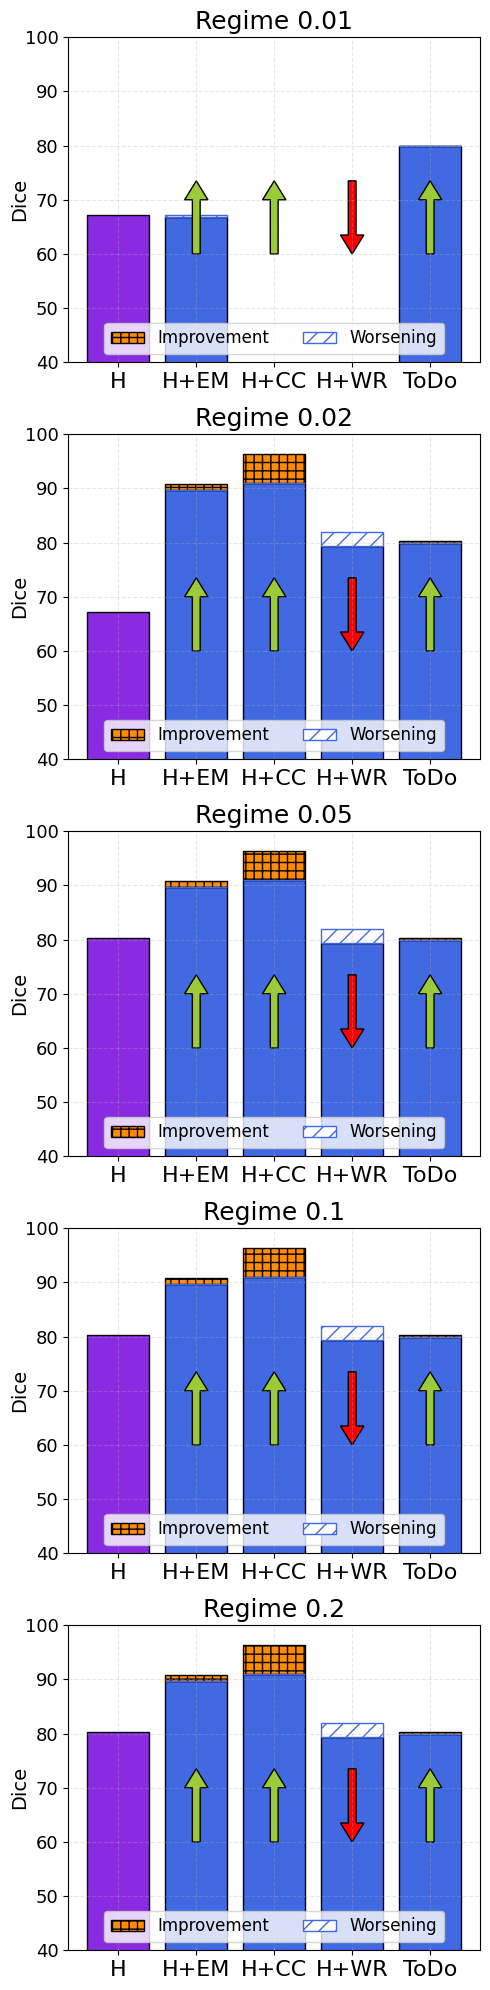

In [25]:
width=0.8

x_labels = ['H', 'H+EM', 'H+CC', 'H+WR', 'ToDo']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(5, 1, figsize=(5, 20), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[j][0].tick_params(axis='x', labelrotation=0)
    axes[j][0].xaxis.set_tick_params(labelsize=16)
    axes[j][0].grid(linestyle='--', linewidth=0.8, alpha=0.3)
    axes[j][0].set_ylabel("Dice", fontsize=14, labelpad=-3)
    axes[j][0].yaxis.set_tick_params(labelsize=13)
    axes[j][0].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[j][0].set_ylim([40, 100])


############################
# Regime 0.01
hebb_001 = [67.15, 0, 0, 0, 0]
values_001 = [0, 67.15-0.28, 0, 0, 80]
improvements_001 = [0, 0, 0, 0, 0]
worsening_001 = [0, 0.28, 0, 0, 0]

axes[0,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.02
hebb_001 = [67.15, 0, 0, 0, 0]
values_001 = [0, 89.66, 91, 82-2.7, 80]
improvements_001 = [0, 1.2, 5.4, 0, 0.3]
worsening_001 = [0, 0, 0, 2.7, 0]

axes[1,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[1,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[1,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[1,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[1,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
hebb_001 = [80.34, 0, 0, 0, 0]
values_001 = [0, 89.66, 91, 82-2.7, 80]
improvements_001 = [0, 1.2, 5.4, 0, 0.3]
worsening_001 = [0, 0, 0, 2.7, 0]

axes[2,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[2,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[2,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[2,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[2,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
hebb_001 = [80.34, 0, 0, 0, 0]
values_001 = [0, 89.66, 91, 82-2.7, 80]
improvements_001 = [0, 1.2, 5.4, 0, 0.3]
worsening_001 = [0, 0, 0, 2.7, 0]

axes[3,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[3,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[3,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[3,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[3,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
hebb_001 = [80.34, 0, 0, 0, 0]
values_001 = [0, 89.66, 91, 82-2.7, 80]
improvements_001 = [0, 1.2, 5.4, 0, 0.3]
worsening_001 = [0, 0, 0, 2.7, 0]

axes[4,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[4,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[4,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[4,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[4,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')

plt.tight_layout()
plt.savefig("./figures/ph2_plots_v.pdf", format="pdf", bbox_inches="tight")
plt.show()

<h3>GlaS Dataset</h3>

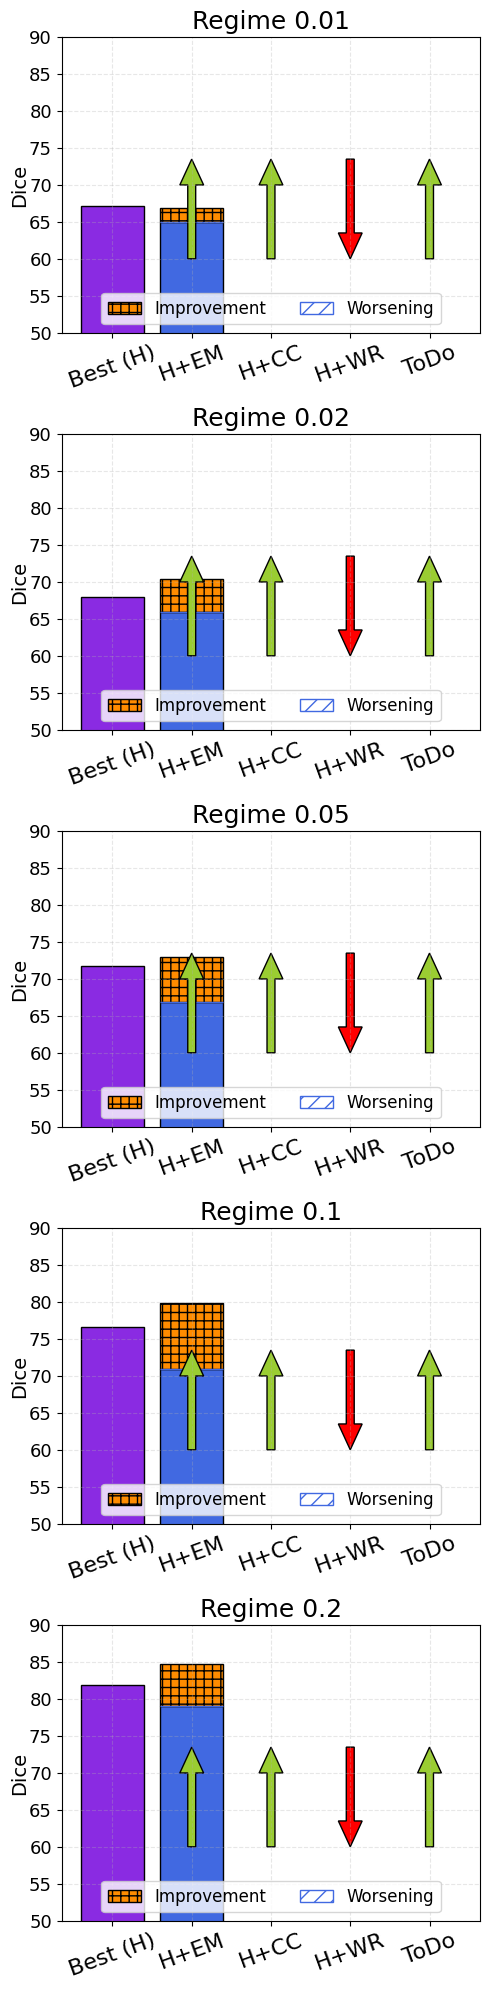

In [50]:
width=0.8

x_labels = ['Best (H)', 'H+EM', 'H+CC', 'H+WR', 'ToDo']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(5, 1, figsize=(5, 20), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[j][0].tick_params(axis='x', labelrotation=20)
    axes[j][0].xaxis.set_tick_params(labelsize=16)
    axes[j][0].grid(linestyle='--', linewidth=0.8, alpha=0.3)
    axes[j][0].set_ylabel("Dice", fontsize=14, labelpad=0)
    axes[j][0].yaxis.set_tick_params(labelsize=13)
    axes[j][0].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[j][0].set_ylim([50, 90])


############################
# Regime 0.01
hebb_001 = [67.15, 0, 0, 0, 0]
values_001 = [0, 64.96, 0, 0, 0]
improvements_001 = [0, (66.87-64.96), 0, 0, 0]
worsening_001 = [0, 0, 0, 0, 0]

axes[0,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.02
hebb_002 = [67.97, 0, 0, 0, 0]
values_002 = [0, 65.91, 0, 0, 0]
improvements_002 = [0, (70.34-65.91), 0, 0, 0]
worsening_002 = [0, 0, 0, 0, 0]

axes[1,0].bar(x_labels, hebb_002, width=width, edgecolor="black", color='blueviolet')
axes[1,0].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[1,0].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[1,0].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[1,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
hebb_005 = [71.74, 0, 0, 0, 0]
values_005 = [0, 66.89, 0, 0, 0]
improvements_005 = [0, (73.01-66.89), 0, 0, 0]
worsening_005 = [0, 0, 0, 0, 0]

axes[2,0].bar(x_labels, hebb_005, width=width, edgecolor="black", color='blueviolet')
axes[2,0].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[2,0].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[2,0].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[2,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[2,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
hebb_01 = [76.69, 0, 0, 0, 0]
values_01 = [0, 70.94, 0, 0, 0]
improvements_01 = [0, (79.82-70.94), 0, 0, 0]
worsening_01 = [0, 0, 0, 0, 0]

axes[3,0].bar(x_labels, hebb_01, width=width, edgecolor="black", color='blueviolet')
axes[3,0].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[3,0].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[3,0].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[3,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
hebb_02 = [81.93, 0, 0, 0, 0]
values_02 = [0, 79.03, 0, 0, 0]
improvements_02 = [0, (84.72-79.03), 0, 0, 0]
worsening_02 = [0, 0, 0, 0, 0]

axes[4,0].bar(x_labels, hebb_02, width=width, edgecolor="black", color='blueviolet')
axes[4,0].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[4,0].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[4,0].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[4,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')

plt.tight_layout()
plt.savefig("./figures/glas_plots_v.pdf", format="pdf", bbox_inches="tight")
plt.show()

<h3>Human Eyes Dataset</h3>

<h2>Old Horizontal</h2>

In [ ]:
width=0.8

x_labels = ['H', 'H + EM', 'H + CC', 'H + WR', 'ToDo']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(1, 5, figsize=(16, 2.5), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[0][j].tick_params(axis='x', labelrotation=22)
    axes[0][j].xaxis.set_tick_params(labelsize=11)
    axes[0][j].grid(linestyle='--', linewidth=0.8, alpha=0.3)
    axes[0][j].set_ylabel("Dice", fontsize=12, labelpad=-3)
    axes[0][j].yaxis.set_tick_params(labelsize=9)
    axes[0][j].set_title('Regime {}'.format(regimes[j]), fontsize=14)
    axes[0][j].set_ylim([40, 100])


############################
# Regime 0.01
hebb_001 = [80.34, 0, 0, 0, 0]
values_001 = [0, 89.66, 91, 82-2.7, 80]
improvements_001 = [0, 1.2, 5.4, 0, 0.3]
worsening_001 = [0, 0, 0, 2.7, 0]

axes[0,0].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,0].legend(ncol=2, fontsize=8, loc='lower center')

############################
# Regime 0.02
hebb_001 = [80.34, 0, 0, 0, 0]
values_001 = [0, 89.66, 91, 82-2.7, 80]
improvements_001 = [0, 1.2, 5.4, 0, 0.3]
worsening_001 = [0, 0, 0, 2.7, 0]

axes[0,1].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,1].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,1].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,1].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,1].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,1].legend(ncol=2, fontsize=8, loc='lower center')

############################
# Regime 0.05
hebb_001 = [80.34, 0, 0, 0, 0]
values_001 = [0, 89.66, 91, 82-2.7, 80]
improvements_001 = [0, 1.2, 5.4, 0, 0.3]
worsening_001 = [0, 0, 0, 2.7, 0]

axes[0,2].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,2].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,2].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,2].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,2].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,2].legend(ncol=2, fontsize=8, loc='lower center')

############################
# Regime 0.1
hebb_001 = [80.34, 0, 0, 0, 0]
values_001 = [0, 89.66, 91, 82-2.7, 80]
improvements_001 = [0, 1.2, 5.4, 0, 0.3]
worsening_001 = [0, 0, 0, 2.7, 0]

axes[0,3].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,3].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,3].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,3].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,3].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,3].legend(ncol=2, fontsize=8, loc='lower center')

############################
# Regime 0.2
hebb_001 = [80.34, 0, 0, 0, 0]
values_001 = [0, 89.66, 91, 82-2.7, 80]
improvements_001 = [0, 1.2, 5.4, 0, 0.3]
worsening_001 = [0, 0, 0, 2.7, 0]

axes[0,4].bar(x_labels, hebb_001, width=width, edgecolor="black", color='blueviolet')
axes[0,4].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,4].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,4].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,4].arrow(x=1, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=2, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=3, y=60+10+3.5, dx=0, dy=-10, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].arrow(x=4, y=60, dx=0, dy=10, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=3.5)
axes[0,4].legend(ncol=2, fontsize=8, loc='lower center')

plt.tight_layout()
plt.savefig("./figures/ph2_plots_h.pdf", format="pdf", bbox_inches="tight")
plt.show()